In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

In [ ]:
class_names = dataset.class_names
class_names

In [ ]:
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
      ax= plt.subplot(3,4,i+1)
      plt.imshow(image_batch[i].numpy().astype("uint8"))
      plt.axis("off")
      plt.title(class_names[label_batch[0]])

In [ ]:
len(dataset)
EPOCHS=50

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [23]:
data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=5,
    epochs=50
)

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

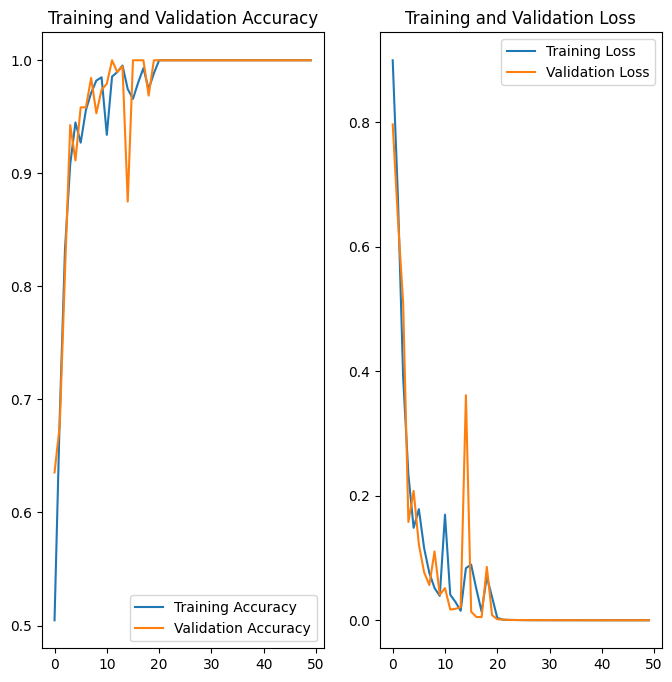

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

actual label:  Potato___Late_blight
1/1 [==============================] - 1s 849ms/step
prdicted label:  Potato___Late_blight


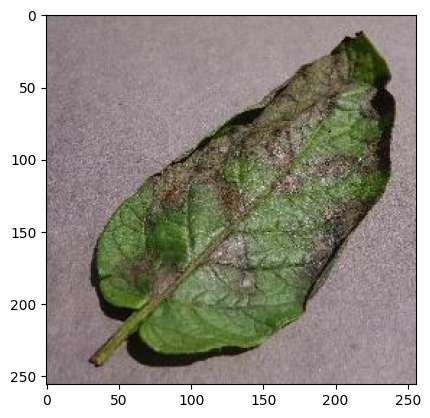

In [34]:
import numpy as np
for image_batch,label_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype("uint8")
    first_label=label_batch[0].numpy()
    plt.imshow(first_image)
    print("actual label: ",class_names[first_label])
    predict=model.predict(image_batch)
    print("prdicted label: ",class_names[np.argmax(predict)])

TypeError: 'numpy.ndarray' object is not callable

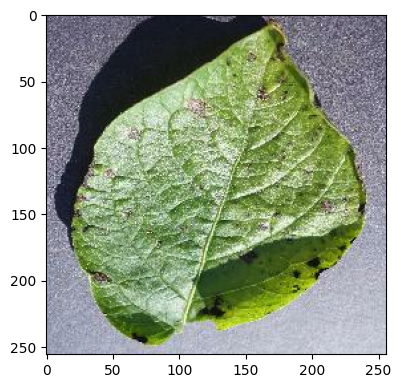

In [35]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [39]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1/assets


INFO:tensorflow:Assets written to: ../models/1/assets


In [37]:
model.save("../potatoes.h5")